## Testing work

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preprocess FoodSeg103

In [19]:
import os
import json
import base64
import zlib
import cv2

from PIL import Image
from io import BytesIO
import numpy as np
from tqdm import tqdm

def get_class_and_tag_id_mapping(meta_dir: str):
    with open(meta_dir, 'r') as file:
        meta_data = json.load(file)

    class_mapping = {}
    tag_mapping = {}
    count = 1
    for meta_cls in meta_data['classes']:
        class_mapping[meta_cls["id"]] = {"id": count, "name": meta_cls["title"]}
        count += 1

    for meta_tags in meta_data['tags']:
        tag_mapping[meta_tags["id"]] = {"id": count, "name": meta_tags["name"]}
        count += 1

    return class_mapping, tag_mapping

In [20]:
def decode_bitmap(bitmap_data, origin, size):
    compressed_data = base64.b64decode(bitmap_data)
    decoded = zlib.decompress(compressed_data)
    mask_img = Image.open(BytesIO(decoded)).convert("L")
    full_mask = Image.new("L", size, 0)
    full_mask.paste(mask_img, tuple(origin))
    return np.array(full_mask, dtype=np.uint8)

def extract_bbox(mask):
    pos = np.where(mask)
    if pos[0].size == 0 or pos[1].size == 0:
        print('No bbox')
        return None
    xmin = int(np.min(pos[1]))
    xmax = int(np.max(pos[1]))
    ymin = int(np.min(pos[0]))
    ymax = int(np.max(pos[0]))
    return [xmin, ymin, xmax - xmin, ymax - ymin]

def mask_to_coco_polygons(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    for contour in contours:
        contour = contour.flatten().tolist()
        if len(contour) >= 6:  # at least 3 points
            polygons.append(contour)
        else:
            print("Contour length: ", len(contour))
    if not polygons:
        print('No polygons')
    return polygons


def convert_annotations(input_dir, class_id_mapping, tag_id_mapping):
    coco = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    class_id_map = {}
    annotation_id = 1

    for filename in tqdm(os.listdir(input_dir + '/ann')):
        if not filename.endswith(".json"):
            continue

        ann_path = os.path.join(input_dir, f'ann/{filename}')
        image_path = os.path.join(input_dir, f'img/{filename.replace(".json", "")}')

        if not os.path.exists(image_path):
            continue

        with open(ann_path) as f:
            ann_data = json.load(f)

        width = ann_data["size"]["width"]
        height = ann_data["size"]["height"]

        coco["images"].append({
            "id": int(filename.replace(".jpg", "").replace(".json", "")),
            "file_name": filename.replace(".json", ""),
            "width": width,
            "height": height
        })

        for obj in ann_data.get("objects", []):
            if obj["geometryType"] != "bitmap":
                continue

            category_id = class_id_mapping[obj["classId"]]["id"]

            bitmap = obj["bitmap"]
            mask = decode_bitmap(bitmap["data"], bitmap["origin"], (width, height))
            bbox = extract_bbox(mask)
            polygons = mask_to_coco_polygons(mask)

            if polygons == []:
                continue

            coco["annotations"].append({
                "id": annotation_id,
                "image_id": int(filename.replace(".json", "").replace(".jpg", "")),
                "category_id": category_id,
                "bbox": bbox,
                "area": int(np.sum(mask > 0)),
                "iscrowd": 0,
                "segmentation": polygons
            })

            annotation_id += 1

            # Write categories if not there

            curr_cat = {
                "id": category_id,
                "name": class_id_mapping[obj["classId"]]["name"],
                "supercategory_id": tag_id_mapping[obj["tags"][0]["tagId"]]["id"],
                "supercategory": tag_id_mapping[obj["tags"][0]["tagId"]]["name"]
            }

            if curr_cat not in coco["categories"]:
              coco["categories"].append(curr_cat)

    return coco


# Main
if __name__ == "__main__":

    meta_dir = "/content/drive/MyDrive/foodseg103/meta.json"

    class_id_mapping, tag_id_mapping = get_class_and_tag_id_mapping(meta_dir)

    train_input_dir = "/content/drive/MyDrive/foodseg103/train"
    test_input_dir = "/content/drive/MyDrive/foodseg103/test"

    train_output_path = "/content/drive/MyDrive/foodseg103/train.json"
    test_output_path = "/content/drive/MyDrive/foodseg103/test.json"

    train_formatted_ann_data = convert_annotations(train_input_dir, class_id_mapping, tag_id_mapping)
    test_formatted_ann_data = convert_annotations(test_input_dir, class_id_mapping, tag_id_mapping)

    with open(train_output_path, "w") as f:
        json.dump(train_formatted_ann_data, f)

    with open(test_output_path, "w") as f:
        json.dump(test_formatted_ann_data, f)

    print(f"✅ COCO annotations saved to: {train_output_path} and {test_output_path}")

  0%|          | 9/4983 [00:00<03:04, 26.90it/s]

Contour length:  2
Contour length:  2


  1%|          | 32/4983 [00:01<02:06, 39.02it/s]

Contour length:  2


  1%|          | 59/4983 [00:43<2:01:01,  1.47s/it]

Contour length:  2
Contour length:  4


  3%|▎         | 134/4983 [00:47<05:57, 13.58it/s]

Contour length:  2
Contour length:  2


  4%|▍         | 187/4983 [00:50<03:14, 24.69it/s]

Contour length:  2


  8%|▊         | 378/4983 [00:57<02:40, 28.66it/s]

Contour length:  2


 12%|█▏        | 616/4983 [01:07<03:19, 21.90it/s]

Contour length:  4


 13%|█▎        | 628/4983 [01:08<02:23, 30.27it/s]

Contour length:  2


 17%|█▋        | 870/4983 [01:16<01:30, 45.23it/s]

Contour length:  4


 19%|█▉        | 936/4983 [01:19<01:45, 38.26it/s]

Contour length:  2
Contour length:  4
Contour length:  2


 20%|█▉        | 996/4983 [01:22<02:56, 22.64it/s]

Contour length:  2
Contour length:  4
Contour length:  2


 22%|██▏       | 1085/4983 [01:25<01:51, 35.10it/s]

Contour length:  2


 22%|██▏       | 1090/4983 [01:25<03:13, 20.17it/s]

Contour length:  2


 24%|██▍       | 1184/4983 [01:29<02:22, 26.73it/s]

Contour length:  2
No polygons


 24%|██▍       | 1195/4983 [01:30<02:56, 21.52it/s]

Contour length:  2


 26%|██▌       | 1284/4983 [01:34<01:27, 42.25it/s]

Contour length:  2


 26%|██▌       | 1293/4983 [01:35<02:45, 22.29it/s]

Contour length:  2
Contour length:  2


 27%|██▋       | 1353/4983 [01:37<02:03, 29.43it/s]

Contour length:  2


 28%|██▊       | 1415/4983 [01:40<01:56, 30.58it/s]

Contour length:  4


 31%|███▏      | 1561/4983 [01:46<01:29, 38.38it/s]

Contour length:  2


 32%|███▏      | 1594/4983 [01:48<01:42, 33.17it/s]

Contour length:  2
Contour length:  2


 34%|███▍      | 1689/4983 [01:51<01:14, 44.17it/s]

Contour length:  4
Contour length:  4
Contour length:  2


 35%|███▍      | 1736/4983 [01:52<01:15, 43.28it/s]

Contour length:  2
Contour length:  2


 36%|███▌      | 1785/4983 [01:54<01:52, 28.55it/s]

Contour length:  2


 39%|███▉      | 1941/4983 [02:00<02:08, 23.76it/s]

Contour length:  2
Contour length:  2


 40%|███▉      | 1978/4983 [02:02<02:08, 23.44it/s]

Contour length:  4


 41%|████▏     | 2057/4983 [02:05<01:14, 39.14it/s]

Contour length:  2


 42%|████▏     | 2080/4983 [02:05<01:02, 46.16it/s]

Contour length:  2


 45%|████▍     | 2229/4983 [02:11<02:05, 21.87it/s]

Contour length:  4


 46%|████▌     | 2287/4983 [02:14<01:33, 28.87it/s]

Contour length:  2
Contour length:  2
Contour length:  4
Contour length:  2


 47%|████▋     | 2333/4983 [02:15<01:21, 32.68it/s]

Contour length:  2


 48%|████▊     | 2375/4983 [02:17<01:49, 23.81it/s]

Contour length:  4
Contour length:  2


 48%|████▊     | 2405/4983 [02:18<01:16, 33.56it/s]

Contour length:  4
Contour length:  2


 49%|████▊     | 2419/4983 [02:19<01:34, 27.02it/s]

Contour length:  2


 50%|█████     | 2511/4983 [02:22<00:57, 42.92it/s]

Contour length:  2


 52%|█████▏    | 2587/4983 [02:24<01:02, 38.27it/s]

Contour length:  4


 53%|█████▎    | 2654/4983 [02:26<00:51, 44.99it/s]

Contour length:  2


 54%|█████▎    | 2677/4983 [02:26<00:45, 51.16it/s]

Contour length:  2
Contour length:  2


 56%|█████▋    | 2806/4983 [02:33<01:10, 30.77it/s]

Contour length:  2


 57%|█████▋    | 2865/4983 [02:35<00:40, 52.10it/s]

Contour length:  4
Contour length:  4


 63%|██████▎   | 3120/4983 [02:46<01:17, 24.10it/s]

Contour length:  4
Contour length:  2


 64%|██████▎   | 3165/4983 [02:47<00:33, 54.71it/s]

Contour length:  2


 66%|██████▌   | 3270/4983 [02:51<00:41, 41.46it/s]

Contour length:  2


 66%|██████▌   | 3285/4983 [02:52<01:21, 20.91it/s]

Contour length:  2


 67%|██████▋   | 3315/4983 [02:54<01:26, 19.31it/s]

Contour length:  2


 67%|██████▋   | 3351/4983 [02:56<01:17, 21.11it/s]

Contour length:  2


 68%|██████▊   | 3405/4983 [03:00<02:14, 11.76it/s]

Contour length:  2


 69%|██████▉   | 3449/4983 [03:03<01:53, 13.48it/s]

Contour length:  4
Contour length:  2
Contour length:  4
Contour length:  4
Contour length:  4


 71%|███████   | 3546/4983 [03:08<01:29, 16.13it/s]

Contour length:  2


 72%|███████▏  | 3594/4983 [03:11<01:01, 22.58it/s]

Contour length:  4
Contour length:  4


 75%|███████▍  | 3718/4983 [03:17<00:47, 26.49it/s]

Contour length:  2


 75%|███████▌  | 3744/4983 [03:18<01:01, 20.24it/s]

Contour length:  4
Contour length:  4


 75%|███████▌  | 3756/4983 [03:19<00:53, 22.92it/s]

Contour length:  2


 78%|███████▊  | 3886/4983 [03:25<00:37, 28.99it/s]

Contour length:  2


 80%|███████▉  | 3974/4983 [03:29<00:26, 37.51it/s]

Contour length:  4
Contour length:  2


 82%|████████▏ | 4107/4983 [03:33<00:35, 24.36it/s]

Contour length:  2


 83%|████████▎ | 4128/4983 [03:34<00:24, 35.01it/s]

Contour length:  4
No polygons


 84%|████████▍ | 4184/4983 [03:36<00:33, 23.58it/s]

Contour length:  4
No polygons


 85%|████████▌ | 4256/4983 [03:38<00:23, 30.57it/s]

Contour length:  2


 88%|████████▊ | 4388/4983 [03:44<00:14, 40.18it/s]

Contour length:  2


 89%|████████▊ | 4415/4983 [03:45<00:16, 33.79it/s]

Contour length:  2


 89%|████████▉ | 4440/4983 [03:46<00:38, 14.05it/s]

Contour length:  2


 90%|████████▉ | 4477/4983 [03:48<00:21, 24.06it/s]

Contour length:  2


 91%|█████████ | 4535/4983 [03:50<00:13, 32.19it/s]

Contour length:  2


 92%|█████████▏| 4595/4983 [03:53<00:22, 17.57it/s]

Contour length:  2


 98%|█████████▊| 4902/4983 [04:06<00:02, 30.16it/s]

Contour length:  2
Contour length:  4
Contour length:  2


 99%|█████████▉| 4936/4983 [04:08<00:02, 18.00it/s]

Contour length:  4


 99%|█████████▉| 4953/4983 [04:09<00:01, 15.13it/s]

Contour length:  2


  1%|          | 14/2135 [00:00<00:37, 56.82it/s]

Contour length:  2
Contour length:  2
Contour length:  2


  3%|▎         | 61/2135 [00:15<04:12,  8.22it/s]

Contour length:  2
Contour length:  2


  6%|▌         | 122/2135 [00:16<00:40, 49.45it/s]

Contour length:  2
Contour length:  4


  9%|▊         | 183/2135 [00:17<00:29, 66.88it/s]

Contour length:  2


  9%|▉         | 197/2135 [00:18<00:39, 49.52it/s]

Contour length:  2
Contour length:  2


 11%|█         | 225/2135 [00:18<00:34, 54.89it/s]

Contour length:  4


 12%|█▏        | 259/2135 [00:19<00:31, 59.30it/s]

Contour length:  2


 13%|█▎        | 271/2135 [00:19<00:38, 48.42it/s]

Contour length:  2
Contour length:  2
Contour length:  4


 14%|█▍        | 309/2135 [00:20<00:32, 56.29it/s]

Contour length:  4
Contour length:  4


 17%|█▋        | 355/2135 [00:21<00:34, 51.37it/s]

Contour length:  2


 20%|██        | 430/2135 [00:22<00:36, 47.01it/s]

Contour length:  2


 22%|██▏       | 462/2135 [00:23<00:38, 43.80it/s]

Contour length:  2
Contour length:  2
Contour length:  2
Contour length:  2


 23%|██▎       | 501/2135 [00:24<00:33, 48.75it/s]

Contour length:  4


 26%|██▋       | 561/2135 [00:25<00:31, 50.62it/s]

Contour length:  2
Contour length:  2
Contour length:  2


 27%|██▋       | 582/2135 [00:26<00:28, 53.80it/s]

Contour length:  4
Contour length:  2


 29%|██▉       | 622/2135 [00:26<00:21, 68.89it/s]

Contour length:  4
Contour length:  2
Contour length:  2


 31%|███       | 655/2135 [00:27<00:21, 69.58it/s]

Contour length:  2
Contour length:  2


 31%|███▏      | 670/2135 [00:27<00:25, 57.29it/s]

Contour length:  2


 33%|███▎      | 704/2135 [00:28<00:28, 50.71it/s]

Contour length:  2
Contour length:  2


 34%|███▍      | 729/2135 [00:28<00:24, 57.96it/s]

Contour length:  2
Contour length:  2


 38%|███▊      | 809/2135 [00:30<00:20, 63.46it/s]

Contour length:  2


 39%|███▉      | 833/2135 [00:30<00:24, 54.00it/s]

Contour length:  2


 40%|███▉      | 852/2135 [00:30<00:25, 49.83it/s]

Contour length:  2
Contour length:  2


 51%|█████     | 1079/2135 [00:35<00:19, 53.71it/s]

Contour length:  4
Contour length:  4
Contour length:  2
Contour length:  4


 52%|█████▏    | 1102/2135 [00:35<00:16, 61.33it/s]

Contour length:  2
Contour length:  2


 53%|█████▎    | 1130/2135 [00:35<00:18, 55.02it/s]

Contour length:  2


 55%|█████▌    | 1181/2135 [00:36<00:17, 54.81it/s]

Contour length:  2


 59%|█████▉    | 1266/2135 [00:38<00:18, 47.74it/s]

Contour length:  4
No polygons


 60%|██████    | 1291/2135 [00:39<00:20, 41.80it/s]

Contour length:  2


 66%|██████▌   | 1409/2135 [00:41<00:10, 70.55it/s]

Contour length:  4


 67%|██████▋   | 1427/2135 [00:41<00:09, 75.20it/s]

Contour length:  2


 68%|██████▊   | 1458/2135 [00:42<00:12, 53.15it/s]

Contour length:  2
Contour length:  2


 69%|██████▊   | 1464/2135 [00:42<00:14, 47.52it/s]

Contour length:  2
Contour length:  4
Contour length:  2
Contour length:  2


 70%|██████▉   | 1485/2135 [00:42<00:11, 54.69it/s]

Contour length:  2
Contour length:  2
Contour length:  2
Contour length:  2
Contour length:  4
Contour length:  4


 72%|███████▏  | 1542/2135 [00:43<00:08, 68.49it/s]

Contour length:  2


 77%|███████▋  | 1639/2135 [00:44<00:07, 67.87it/s]

Contour length:  2
Contour length:  2


 78%|███████▊  | 1659/2135 [00:45<00:09, 49.38it/s]

Contour length:  4


 79%|███████▊  | 1678/2135 [00:45<00:08, 51.39it/s]

Contour length:  2
Contour length:  2


 82%|████████▏ | 1758/2135 [00:47<00:07, 52.76it/s]

Contour length:  2
Contour length:  2


 85%|████████▍ | 1806/2135 [00:47<00:05, 63.65it/s]

Contour length:  4


 85%|████████▌ | 1821/2135 [00:48<00:05, 58.93it/s]

Contour length:  2
Contour length:  2


 87%|████████▋ | 1857/2135 [00:48<00:04, 62.22it/s]

Contour length:  2


 89%|████████▉ | 1906/2135 [00:49<00:03, 62.79it/s]

Contour length:  2
Contour length:  2


 91%|█████████ | 1946/2135 [00:50<00:03, 53.27it/s]

Contour length:  2
Contour length:  2
Contour length:  2
Contour length:  4


 94%|█████████▎| 2000/2135 [00:51<00:03, 41.18it/s]

Contour length:  2


 97%|█████████▋| 2067/2135 [00:52<00:01, 51.76it/s]

Contour length:  4


100%|██████████| 2135/2135 [00:54<00:00, 39.37it/s]


✅ COCO annotations saved to: /content/drive/MyDrive/foodseg103/train.json and /content/drive/MyDrive/foodseg103/test.json


In [3]:
meta_dir = "/content/drive/MyDrive/foodseg103/meta.json"
class_id_mapping, tag_id_mapping = get_class_and_tag_id_mapping(meta_dir)

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from PIL import Image

def draw_image_with_boxes(image_path, annotations, categories):
    """
    Draws bounding boxes and category labels from COCO-style annotations.

    Args:
        image_path (str): Path to the image.
        annotations (list): List of annotations with:
            - bbox: [x, y, width, height]
            - category_id: int
            - segmentation: list of polygons (each polygon is a list of x,y coords)
            - image_id: int
        categories (list): List of dicts with 'id' and 'name' fields.
                           e.g., [{"id": 1, "name": "rice"}, ...]
    """
    # Build a mapping from category_id to name
    category_id_to_name = {cat["id"]: cat["name"] for cat in categories}

    # Load image
    image = Image.open(image_path).convert("RGB")
    filename = os.path.splitext(os.path.basename(image_path))[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    ax = plt.gca()

    for ann in annotations:
        if ann["image_id"] != int(filename):
          continue
        bbox = ann["bbox"]
        category_id = ann["category_id"]
        label = category_id_to_name.get(category_id, f"ID {category_id}")

        # Draw rectangle
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=2, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)

        # Draw label
        ax.text(bbox[0], bbox[1] - 5, label,
                color='white', backgroundcolor='red', fontsize=10)

        # Draw polygon masks
        if "segmentation" in ann:
            segmentations = ann["segmentation"]
            # COCO segmentation can be a list of polygons or a single polygon list
            # Ensure it's a list of polygons
            print(len(segmentations))
            print(segmentations)
            if isinstance(segmentations[0], list):
                polygons = segmentations
            else:
                polygons = [segmentations]

            for poly in polygons:
                # poly is a flat list: [x1, y1, x2, y2, ..., xn, yn]
                # Convert to Nx2 array of points
                poly_points = [(poly[i], poly[i+1]) for i in range(0, len(poly), 2)]
                polygon_patch = Polygon(poly_points, closed=True, linewidth=1,
                                        edgecolor='yellow', facecolor='yellow', alpha=0.4)
                ax.add_patch(polygon_patch)

    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [17]:
with open("/content/drive/MyDrive/foodseg103/train.json", 'r') as f:
    train_formatted_ann_data = json.load(f)

1
[[98, 78, 97, 79, 94, 79, 93, 80, 92, 80, 91, 81, 90, 81, 87, 84, 86, 84, 85, 85, 85, 86, 82, 89, 82, 90, 81, 91, 81, 92, 80, 93, 80, 96, 79, 97, 79, 98, 78, 99, 78, 100, 77, 101, 77, 104, 75, 106, 75, 107, 73, 109, 72, 108, 72, 107, 71, 106, 71, 105, 70, 104, 70, 102, 69, 101, 69, 99, 68, 98, 68, 97, 67, 96, 67, 94, 66, 93, 66, 92, 64, 90, 64, 89, 63, 88, 62, 88, 60, 90, 59, 90, 58, 91, 58, 92, 57, 93, 57, 94, 56, 95, 56, 96, 55, 97, 55, 98, 54, 99, 54, 101, 53, 102, 53, 105, 52, 106, 52, 109, 51, 110, 51, 115, 50, 116, 50, 118, 67, 118, 68, 119, 75, 119, 76, 120, 79, 120, 80, 121, 83, 121, 84, 122, 85, 122, 86, 123, 88, 123, 89, 124, 91, 124, 92, 125, 93, 125, 94, 126, 96, 126, 97, 127, 98, 127, 99, 128, 99, 129, 97, 131, 96, 131, 95, 132, 94, 132, 92, 134, 91, 134, 90, 135, 89, 135, 88, 136, 87, 136, 86, 137, 86, 138, 85, 139, 85, 146, 84, 147, 83, 147, 83, 148, 84, 149, 84, 152, 85, 153, 85, 156, 86, 157, 86, 158, 87, 159, 87, 160, 88, 161, 88, 162, 89, 163, 90, 163, 91, 164, 92,

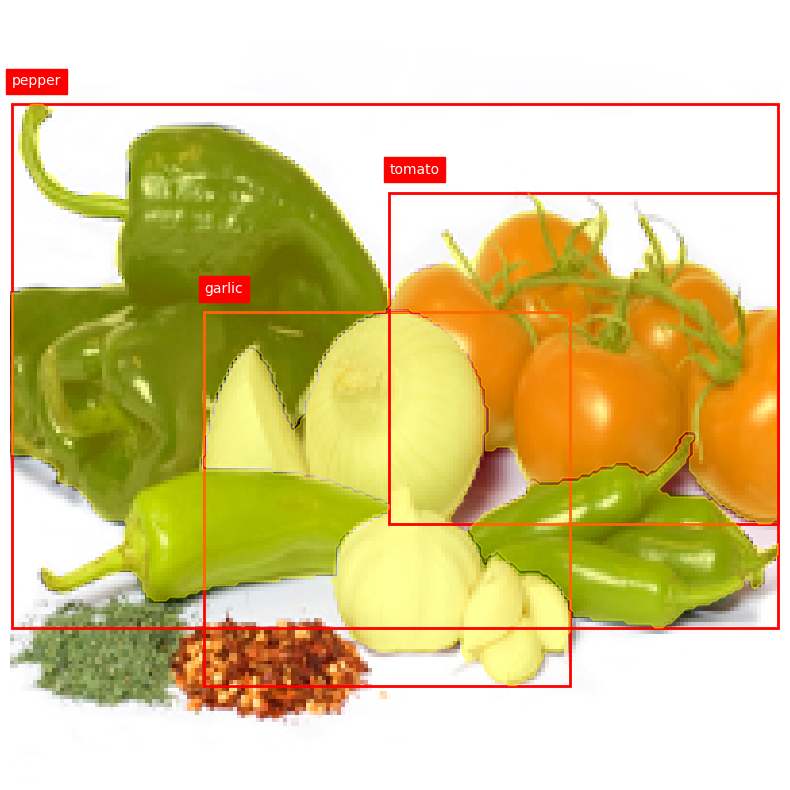

In [26]:
draw_image_with_boxes(
    "/content/drive/MyDrive/foodseg103/train/img/00001080.jpg",
    train_formatted_ann_data["annotations"],
    train_formatted_ann_data["categories"])

# Official code part

#### Utils

In [27]:
import random
import torchvision.transforms.functional as F

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class RandomHorizontalFlip:
    def __init__(self, prob=0.5):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            # image must be a PIL image here
            image = F.hflip(image)

            width, _ = image.size  # PIL image size

            # Flip boxes
            if "boxes" in target:
                boxes = target["boxes"]
                boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
                target["boxes"] = boxes

            # Flip masks (tensor)
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)

        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # converts PIL image to tensor
        return image, target

def get_transform(train=True):
    transforms = []
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    transforms.append(ToTensor())
    return Compose(transforms)


#### Dataset

In [35]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
from pycocotools.coco import COCO

class FoodSegJSONDataset(Dataset):
    def __init__(self, img_dir, ann_path, transforms=None):
        self.image_dir = os.path.join(img_dir, "img")
        self.coco = COCO(ann_path)
        self.image_ids = list(self.coco.imgs.keys())
        self.transforms = transforms


    def __len__(self):
        return len(self.image_ids)


    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(image_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])

        img = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        masks = []

        for ann in anns:
            if ('segmentation' not in ann) or ('bbox' not in ann):
                continue

            masks.append(self.coco.annToMask(ann))
            boxes.append(ann['bbox'])
            labels.append(ann['category_id'])

        if len(masks) == 0:
            return self.__getitem__((idx + 1) % len(self))  # skip bad data

        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # COCO bbox is [x, y, width, height] -> convert to [x1, y1, x2, y2]
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": torch.tensor([image_id]),
            "area": torch.tensor([ann["area"] for ann in anns], dtype=torch.float32),
            "iscrowd": torch.tensor([ann.get("iscrowd", 0) for ann in anns], dtype=torch.int64)
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target




#### Engine

In [36]:
from tqdm import tqdm


def train_one_epoch(model, optimiser, data_loader, device, epoch):
    model.train()
    google_drive_path = '/content/drive/MyDrive/foodseg103'

    count = 0
    for images, targets in tqdm(data_loader, desc=f"Epoch {epoch}"):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimiser.zero_grad()
        losses.backward()
        optimiser.step()

        if count%10 == 0:
          os.makedirs(google_drive_path + "/outputs/models", exist_ok=True)
          torch.save(model.state_dict(), f"{google_drive_path}/outputs/models/model_epoch_{epoch}_checkpoint_{count}.pth")

        count += 1



    print(f"Loss: {losses.item():.4f}")

#### Models

In [37]:
import torchvision

from torchvision.models.detection import (
    maskrcnn_resnet50_fpn_v2,
    MaskRCNN_ResNet50_FPN_V2_Weights,
    faster_rcnn,
    mask_rcnn)


def get_model(num_classes):
    model = maskrcnn_resnet50_fpn_v2(weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1)

    # print(model.roi_heads)
    # print()
    # print()
    # print()

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    hidden_layer = 256
    model.roi_heads.mask_predictor = mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    # print(model.roi_heads)
    # print()

    return model

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import random

def show_image_with_masks(img, pred, categories=None, score_thresh=0.5):
    img = img.permute(1,2,0).numpy()

    plt.figure(figsize=(10,10))
    plt.imshow(img)

    ax = plt.gca()

    masks = pred["masks"]
    boxes = pred["boxes"]
    labels = pred["labels"]
    scores = pred["scores"]

    for i in range(len(masks)):
        if scores[i] < score_thresh:
            continue

        mask = masks[i,0].mul(255).byte().cpu().numpy()
        color = np.random.rand(3,)

        ax.contour(mask, levels=[0.5], colors=[color])

        x1, y1, x2, y2 = boxes[i].detach().cpu().numpy()
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                   fill=False, color=color, linewidth=2))
        label_id = labels[i].item()
        label_name = categories[label_id] if categories and label_id in categories else str(label_id)
        ax.text(x1, y1, f"{label_id}:{scores[i]:.2f}", color=color, fontsize=12,
                bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.2'))

    plt.axis("off")
    plt.tight_layout()
    plt.show()




#### Main.py

In [39]:
# need class_id_mapping mapping

In [40]:
import torch
import json
import os

from torch.utils.data import DataLoader

# from dataset.foodseg_json_dataset import FoodSegJSONDataset
# from models.mask_rcnn import get_model
# from utils.transforms import get_transform
# from engine.train import train_one_epoch
# from utils.visualise import show_image_with_masks


def collate_fn(batch):
    return tuple(zip(*batch))


def load_categories(meta_path):
    with open(meta_path) as f:
        meta = json.load(f)
    return {cat['id']: cat['title'] for cat in meta['classes']}


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"device: {device}")

    # train_data_path = "data/foodseg103/train"
    # test_data_path = "data/foodseg103/test"
    # meta_path = "data/foodseg103/meta.json"

    google_drive_path = '/content/drive/MyDrive/foodseg103'

    train_data_path = os.path.join(google_drive_path, 'train')
    test_data_path = os.path.join(google_drive_path, 'test')
    meta_path = os.path.join(google_drive_path, 'meta.json')

    train_ann_path = os.path.join(google_drive_path, 'train.json')
    test_ann_path = os.path.join(google_drive_path, 'test.json')

    # Dataset and Dataloader
    dataset = FoodSegJSONDataset(train_data_path, train_ann_path, transforms=get_transform(train=True))
    data_loader = DataLoader(dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)

    print("len", len(dataset))

    test_dataset = FoodSegJSONDataset(test_data_path, test_ann_path, transforms=get_transform(train=False))
    # test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

    # Model
    num_classes = len(class_id_mapping.keys()) + 1 # background + category count
    print()
    print(f"num classes: {num_classes}")
    model = get_model(num_classes).to(device)

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimiser = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # Training Loop
    for epoch in range(1):
        train_one_epoch(model, optimiser, data_loader, device, epoch)

    # Visualize predictions on test set
    model.eval()
    with torch.no_grad():
        img, _ = test_dataset[0]
        pred = model([img.to(device)])[0]

    show_image_with_masks(img, pred, class_id_mapping)

In [ ]:
main()

device: cpu
loading annotations into memory...
Done (t=4.14s)
creating index...
index created!
len 4983
loading annotations into memory...
Done (t=1.03s)
creating index...
index created!

num classes: 104


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_v2_coco-73cbd019.pth
100%|██████████| 177M/177M [00:01<00:00, 99.7MB/s]
Epoch 0:   0%|          | 5/1661 [11:14<59:19:21, 128.96s/it]